In [1]:
import strawberryfields as sf
from strawberryfields.ops import Dgate, BSgate, Sgate, Rgate
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle

from qmlt.tf.helpers import make_param
from qmlt.tf import CircuitLearner

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or 

In [2]:
def create_data(samples_per_class: int, intersect_rate: float):
    np.random.seed(0)
    l = samples_per_class
    n = 2
    drop = intersect_rate
    
    sep = int(l * 0.1 * 2)

    X1 = np.array([[-1, -1]]) + drop * np.random.randn(l, n)
    X2 = np.array([[1, 1]]) + drop * np.random.randn(l, n)

    # конкатенируем все в одну матрицу
    # при этом по 20 точек оставим на тест/валидацию
    x, y = np.vstack((X1, X2)), np.hstack([[0] * l, [1] * l])
    x, y = shuffle(x, y, random_state=7)
    
    train_x, train_y = x[sep:], y[sep:]
    test_x, test_y = x[:sep], y[:sep]
    
    return train_x, train_y, test_x, test_y

In [3]:
def func(k, b):
    x = np.array([-1, 0, 1])
    y = x * k + b
    return x, y

In [4]:
def create_linear_data(k, b):
    l = 20
    n = 2
    drop=0.4

    X1, X2 = [], []

    lin_x, lin_y = func(k, b)
    for i in range(len(lin_x)):
        arrs =  np.array([[lin_x[i], lin_y[i]]]) + drop * np.random.randn(l, n)
        for arr in arrs:
            X1.append(arr)

    lin_x, lin_y = func(k, -b)
    for i in range(len(lin_x)):
        arrs =  np.array([[lin_x[i], lin_y[i]]]) + drop * np.random.randn(l, n)
        for arr in arrs:
            X2.append(arr)

    # конкатенируем все в одну матрицу
    # при этом по 20 точек оставим на тест/валидацию
    x, y = np.vstack((X1, X2)), np.hstack([[0] * len(X1), [1] * len(X2)])
    x, y = shuffle(x, y, random_state=7)
    
    sep = int((len(X1) + len(X2)) * 0.1)
    
    train_x, train_y = x[sep:], y[sep:]
    test_x, test_y = x[:sep], y[:sep]
    
    return train_x, train_y, test_x, test_y

In [5]:
def visualize_data(arrayX, arrayY, name='dataset') -> None:
    colors = ['blue', 'red', 'yellow', 'green']
    for k in np.unique(arrayY):
        plt.plot(arrayX[arrayY == k, 0], arrayX[arrayY == k, 1], 'o', label='class {}'.format(k), color=colors[k])
    plt.legend(fontsize=7, ncol=1, facecolor='oldlace', edgecolor='r')
    plt.title(name)
    plt.show()

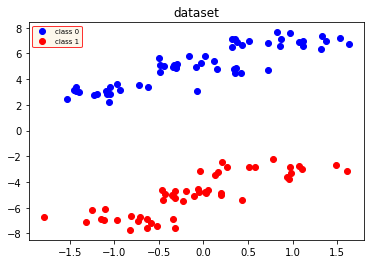


----------------------------- 
 HYPERPARAMETERS: 

batch_size - None (default value)
circuit - User defined function.
decay - 0.01
init_learning_rate - 0.05
log_every - 1
loss - User defined function.
model_dir - None (default value)
optimizer - SGD
outputs_to_predictions - None (default value)
plot_every - 1 (default value)
print_log - True
regularization_strength - 0.1 (default value)
regularizer - No regularizer provided.
task - supervised
warm_start - False

 -----------------------------
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_log_step_count_steps': 100, '_num_worker_replicas': 1, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_global_id_in_cluster': 0, '_evaluation_master': '', '_master': '', '_tf_random_seed': None, '_is_chief': True, '_num_ps_replicas': 0, '_session_config': None, '_model_dir': 'logsAUTO', '_save_summary_steps': 100, '_service': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_

In [7]:
steps = 700
batch_size = 2


def circuit(X):

    params = [make_param(name='phi'+str(i), constant=.5, monitor=True) for i in range(6)]

    eng, q = sf.Engine(2)

    with eng:
        Sgate(1.5, X[:, 0]) | q[0]
        Sgate(1.5, X[:, 1]) | q[1]
        BSgate(params[0], params[1]) | (q[0], q[1])
        Rgate(params[2]) | q[0]
        Rgate(params[3]) | q[1]
        Dgate(params[4]) | q[0]
        Dgate(params[5]) | q[1]

    num_inputs = X.get_shape().as_list()[0]
    state = eng.run('tf', cutoff_dim=10, eval=False, batch_size=num_inputs)

    p0 = state.fock_prob([0, 2])
    p1 = state.fock_prob([2, 0])
    normalization = p0 + p1 + 1e-10
    circuit_output = p1 / normalization

    return circuit_output


def myloss(circuit_output, targets):
    return tf.losses.mean_squared_error(labels=circuit_output, predictions=targets)


def outputs_to_predictions(outpt):
    return tf.round(outpt)

train_x, train_y, test_x, test_y = create_linear_data(k=2, b=5)  # create_data(100, 0.5)

visualize_data(train_x, train_y)

# There are some changes here:
# We decay the learning rate by a factor 1/(1-decay*step) in each step.
# We train_circuit with batches of 2 training inputs (instead of the full batch).
# We also print out the results every 10th step.
# Finally, you can set 'warm start': True to continue previosu training.
# (MAKE SURE YOU RUN THE SAME SCRIPT ONCE WITH A COLD START,
# ELSE YOU GET ERRORS WHEN LOADING THE MODEL!).
# This loads the final parameters from the previous training. You can see
# that the global step starts where it ended the last time you ran the script.
hyperparams = {'circuit': circuit,
               'task': 'supervised',
               'loss': myloss,
               'optimizer': 'SGD',
               'init_learning_rate': 0.05,
               'decay': 0.01,
               'print_log': True,
               'log_every': 1,
               'warm_start': False
               }

learner = CircuitLearner(hyperparams=hyperparams)

learner.train_circuit(X=train_x, Y=train_y, steps=steps, batch_size=batch_size)

test_score = learner.score_circuit(X=test_x, Y=test_y,
                                   outputs_to_predictions=outputs_to_predictions)
# The score_circuit() function returns a dictionary of different metrics.
print("\nPossible scores to print: {}".format(list(test_score.keys())))
# We select the accuracy and loss.
print("Accuracy on test set: ", test_score['accuracy'])
print("Loss on test set: ", test_score['loss'])

# outcomes = learner.run_circuit(X=X_pred,
#                                outputs_to_predictions=outputs_to_predictions)
# # The run_circuit() function returns a dictionary of different outcomes.
# print("\nPossible outcomes to print: {}".format(list(outcomes.keys())))
# # We select the predictions
# print("Predictions for new inputs: {}".format(outcomes['predictions']))